# Diagonal integration using Palette

Palette employs a connected MBG for mosaic integration. However, in the absence of locally shared modalities, the task is essentially diagonal integration, which disrupts MBG connectivity. We implemented this strategy by adding pseudo-modality nodes to the MBG, restoring cross-modality links. 

In this tutorial , we applied Palette on human kidney scRNA-seq and scATAC-seq data from [Muto, Y. et al. (2021)](https://doi.org/10.1038/s41467-021-22368-w) to demonstrate diagonal integration.

## Pseudo-modality matrix construction

In the diagonal integration task, the input data consists of two parts: **(1)** the original modality matrix of the data and **(2)** the pseudo-modality matrix. Here, we show how to generate the **pseudo-modality matrix**.

We first read in the count matrix of both modalities and ATAC gene activity matrix.

In [1]:
library(Seurat)
library(cowplot)
library(dplyr)
library(data.table)
library(tibble)
library(Matrix)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last




In [2]:
# gene activity matrix from Muto, Y. et al.

setwd('../')
ga <- readRDS('./420eca96-b430-46ab-bba7-276ab09604dd.rds')
ga_c <- ga@assays[[1]]@counts
colnames(ga_c) <- paste0(colnames(ga_c),'_ATAC')
ga_m <- ga@meta.data
rownames(ga_m) <- colnames(ga_c)
tmp <- CreateSeuratObject(ga_c,meta.data = ga_m)
rm(ga,ga_c,ga_m)
gc()
ga <- tmp
rm(tmp)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,3033137,162.0,4804064,256.6,4804064,256.6
Vcells,246978509,1884.3,785712083,5994.6,653826125,4988.3


In [3]:
# ATAC count matrix
atac <- Matrix::readMM('./process/atac.mtx')
peak <- fread('./process/peak.csv',data.table = F)
atac_meta <- fread('./process/atac_meta.csv',data.table = F)

In [4]:
atac <- t(atac)
atac <- as(atac,'dgCMatrix')
rownames(atac) <- paste0(peak[,1],'-',peak[,2],'-',peak[,3])
rownames(atac_meta) <- paste0(atac_meta[,1],"_ATAC")
colnames(atac) <- rownames(atac_meta)

'as(<dgTMatrix>, "dgCMatrix")' is deprecated.
Use 'as(., "CsparseMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").



In [5]:
length(intersect(colnames(atac),colnames(ga@assays[[1]]@counts)))

[1] 24205

In [6]:
ga <- subset(ga,cells = colnames(atac))

In [7]:
# RNA count matrix
rna <- Matrix::readMM('./process/rna.mtx')
gene <- fread('./process/gene.csv',data.table = F)
rna_meta <- fread('./process/rna_meta.csv',data.table = F)
rna <- t(rna)
rna <- as(rna,'dgCMatrix')
rownames(rna) <- gene[,2]
colnames(rna) <- rna_meta[,1]
rna_obj <- CreateSeuratObject(rna)
rna_obj <- NormalizeData(rna_obj) %>% FindVariableFeatures()

In [8]:
ga <- NormalizeData(ga)

In [9]:
co_gene <- intersect(rna_obj@assays[[1]]@var.features,
                     rownames(ga@assays[[1]]@counts))

rna_n <- rna_obj@assays[[1]]@data[co_gene,]
atac_n <- ga@assays[[1]]@data[co_gene,]

In [10]:
# check common feature number
length(co_gene)

[1] 1565

In [11]:
ncol(rna_n)
ncol(atac_n)

[1] 19985

[1] 24205

In [12]:
sub <- cbind(rna_n,atac_n)
library(preprocessCore)

# quantile normalize for pseudo-modality matrix
sub_norm <- normalize.quantiles(as.matrix(sub))

rna_q <- sub_norm[,1:19985]
atac_q <- sub_norm[,19986:ncol(sub)]
colnames(rna_q) <- colnames(rna_n)
colnames(atac_q) <- colnames(atac_n)

In [13]:
rownames(rna_q) <- rownames(atac_q) <- rownames(rna_n) <- rownames(atac_q) <- co_gene
# saveRDS(as.data.frame(rna_q),'../RNA/co.rds')
# saveRDS(as.data.frame(atac_q),'../ATAC/co.rds')

In the diagonal integration task, unimodal data can be directly input into the low-dimensional representation after dimensionality reduction. Here, we perform dimensionality reduction on ATAC and RNA.

In [14]:
atac_lsi <- Signac::RunTFIDF(atac) %>% Signac::RunSVD(.,scale.embeddings = F)
# saveRDS(as.data.frame(atac_lsi@cell.embeddings[,2:50]),
#         '../lsi.rds')

Performing TF-IDF normalization

Running SVD

Warning message:
“No assay specified, setting assay as RNA by default.”


In [15]:
rna_obj <- ScaleData(rna_obj) %>% RunPCA()
# saveRDS(as.data.frame(rna_obj[['pca']]@cell.embeddings),
#         '../pca50.rds')
# saveRDS(as.data.frame(rna_obj@assays[[1]]@counts[rna_obj@assays[[1]]@var.features,]),
#        '../X.rds')

Centering and scaling data matrix

PC_ 1 
Positive:  ENSG00000183747, ENSG00000066813, ENSG00000107611, ENSG00000148942, ENSG00000158296, ENSG00000165449, ENSG00000081479, ENSG00000124568, ENSG00000160282, ENSG00000250799 
	   ENSG00000080493, ENSG00000133401, ENSG00000171759, ENSG00000248373, ENSG00000109667, ENSG00000196549, ENSG00000149124, ENSG00000249378, ENSG00000108018, ENSG00000284418 
	   ENSG00000186335, ENSG00000100253, ENSG00000081800, ENSG00000136872, ENSG00000150275, ENSG00000079557, ENSG00000130707, ENSG00000122194, ENSG00000215277, ENSG00000258700 
Negative:  ENSG00000164292, ENSG00000198929, ENSG00000166833, ENSG00000185774, ENSG00000138798, ENSG00000003147, ENSG00000226674, ENSG00000078114, ENSG00000134504, ENSG00000196428 
	   ENSG00000050628, ENSG00000151376, ENSG00000071909, ENSG00000129682, ENSG00000068366, ENSG00000109436, ENSG00000081803, ENSG00000154975, ENSG00000179399, ENSG00000115252 
	   ENSG00000182240, ENSG00000163082, ENSG00000154265, ENSG00000139144, EN

## Data input

After constructing the pseudo-modal matrix, we can use **Palette** to perform diagonal integration. Here, to better demonstrate the operation process of Palette, we use RNA's count matrix as input. In actual integration tasks, users can use RNA's dimensionality reduction matrix (such as PCA embedding) as input

In [16]:
library(PaletteSC)
library(uwot)
library(RColorBrewer)
library(ggplot2)
library(RColorBrewer)
library(scattermore)
library(ggsci)

# Create a Palette object

The object serves as a container that contains both data (like the count matrix) and analysis (like PCA, or clustering results) for multimodal dataset.

**Palette** accepts data in **list format**, with each element representing a feature-by-cell data matrix. The modality and batch information for each input are provided through ```modals``` and ```samples```.

In [17]:
obj <- Create.Palette.Object(data.list = list(rna_obj@assays[[1]]@counts[rna_obj@assays[[1]]@var.features,],
                             rna_q,t(atac_lsi@cell.embeddings[,2:50]),atac_q), 
                               samples = c('Batch1','Batch1','Batch2','Batch2'), 
                               modals = c("rna","co","atac","co"))

rm(rna_obj,rna_q,atac_lsi,atac_q,sub_norm, sub,rna_n,atac_n,ga)

# Data preprocessing

For the scRNA-seq data, we performed standard log-normalization using the NormalizeData function from the Seurat R package. We do not need to performed additional normalization for other modalities

In [18]:
obj <- Normalize.Data(obj,modal = "rna",normal.method = "LogNormalize")

obj@Assays[[2]]@data <- obj@Assays[[2]]@Raw
obj@Assays[[3]]@data <- obj@Assays[[3]]@Raw
obj@Assays[[4]]@data <- obj@Assays[[4]]@Raw

In [19]:
obj <- Add.HVFs(obj, modal = "atac")
obj <- Add.HVFs(obj,modal = "rna")
obj <- Add.HVFs(obj, modal = "co")

No features provide, use all shared features by default.

No features provide, use all shared features by default.

No features provide, use all shared features by default.



## Clustering and representative cells sampling

Within each batch, **Palette** assigns cluster labels to cells using the Louvain algorithm. Next, **Palette** selects a subset of representative cells from each batch. Specifically, silhouette widths (SWs) are computed for all cells based on their clustering labels.
Within each clustering label, cells are ranked by their SW values, and the top 25% (by default) are selected. By sampling representative cells, **Palette** is more robust to the low representative cells and is more computationally effective than using all cells in subsequent calculations.

In [20]:
obj <- Find.Cluster(object = obj, 
                         modal = c("co"),
                         dims = list(1:50),
                         method = c("PCA"))

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 19985
Number of edges: 901228

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9068
Number of communities: 31
Elapsed time: 2 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 24205
Number of edges: 1086255

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8900
Number of communities: 22
Elapsed time: 4 seconds


## Intra-modal joint dimensionality reduction using Bi-sPCA

If modalities are present in only a single batch, standard techniques such as singular value decomposition (SVD), PCA, or latent semantic indexing (LSI) are applied directly. For modalities that appear in multiple batches, **Palette** independently integrating each data modality across batches using **Bi-supervised Principal Component Analysis (Bi-sPCA)**, a new dimensionality reduction model aiming to disentangle biological signals from technical effects. **Bi-sPCA** operates on kernel representations of both biological and technical variation, learning a projection that maximizes biological variation in the embedding while minimizing unwanted technical effects.

The ```IsolatedModalEmbedding``` function is used for data dimensionality reduction. Here, since ATAC inputs a matrix that has already been dimensionality reduced, we do not need to perform further dimensionality reduction on it.

In [21]:
obj <- IsolatedModalEmbedding(obj,modal = 'rna',
                                   method = c('PCA'),
                                   dims = list(1:30))

obj@Assays[[3]]@embedding <- as.matrix(obj@Assays[[3]]@Raw[1:30,])

**Palette** constructs the biological effect kernel using a threshold $T = max\{T_1,\; T_2\}$ to filter unreliable connections, where $T_1$ is a global modality-specific threshold which can set manually by ```max.Angle``` and $T_2=cos(\theta_c+\theta_m)$ is an angular similarity constraint, where $\theta_c$ is the median angle of cell expression vectors within a batch, and $\theta_m$ is is a modality-specific angular offset which can set manually by ```Angle.var```.

In [22]:
obj <- Find.Subspace(obj,modal = c("co"),
                     lambda = list(0.9),
                     sub.dims = list(1:30),
                     Angle.var = c(30),
                     max.Angle = c(60))

Performing dimensionality reduction and L2 normalization. 


Dimensionality reduction and L2 normalization done! 


Identifying batch-specific cluster median cosine similarity. 


Done !



## MBG-guided inferring of missing modality matrices and Cross-batch alignment

**Palette** constructs a **mosaic bipartite graph (MBG)** to capture the structural topology of data. The **MBG** is an undirected, unweighted, and connected bipartite graph where nodes represent batches and modalities, and edges indicate the presence of a given modality in a batch. This graph sequentially connects the partially overlapping modalities across batches. For batches that lack measurements in specific modalities, **Palette** identifies shortest paths in the **MBG** that connect the batch to the missing modality. These paths define biologically informed propagation routes across the latent spaces of the shared modalities, enabling inference of low-dimensional representations for unobserved modalities by transferring information through matched neighbors across batches. **Palette** employs multiple paths to infer the missing data for each cell in a weighted approach. Finally, both real and inferred representations of all batches are jointly embedded into a unified low-dimensional space using **Bi-sPCA** again.

In [23]:
obj <- Run.Palette(obj)

Constructing MBG.

MBG Done!

Inferring missing modality matrices guided by MBG.


Performing inference for modal "atac" of  sample "Batch1" in embedding space.


Performing inference for modal "rna" of  sample "Batch2" in embedding space.


MBG-guided inferring Done.


Cross-batch alignment.


Palette integration Done! 




## Visualization

In [24]:
meta <- readRDS('./meta.rds')
meta <- meta[,c(1,2,4)]
colnames(meta) <- c('Barcode','CellType','Modality')

In [25]:
Palette_emb <- as.matrix(obj@Int.result[["bind"]][rownames(meta),])
Palette_umap = as.data.frame(umap(Palette_emb))
colnames(Palette_umap) = c("UMAP1", "UMAP2")
Palette_umap = cbind.data.frame(meta, Palette_umap)
fig.size = function(height, width) {
    options(repr.plot.height = height, repr.plot.width = width, repr.plot.res = 300)
}

Warning message in brewer.pal(12, "Accent"):
“n too large, allowed maximum for palette Accent is 8
Returning the palette you asked for with that many colors
”


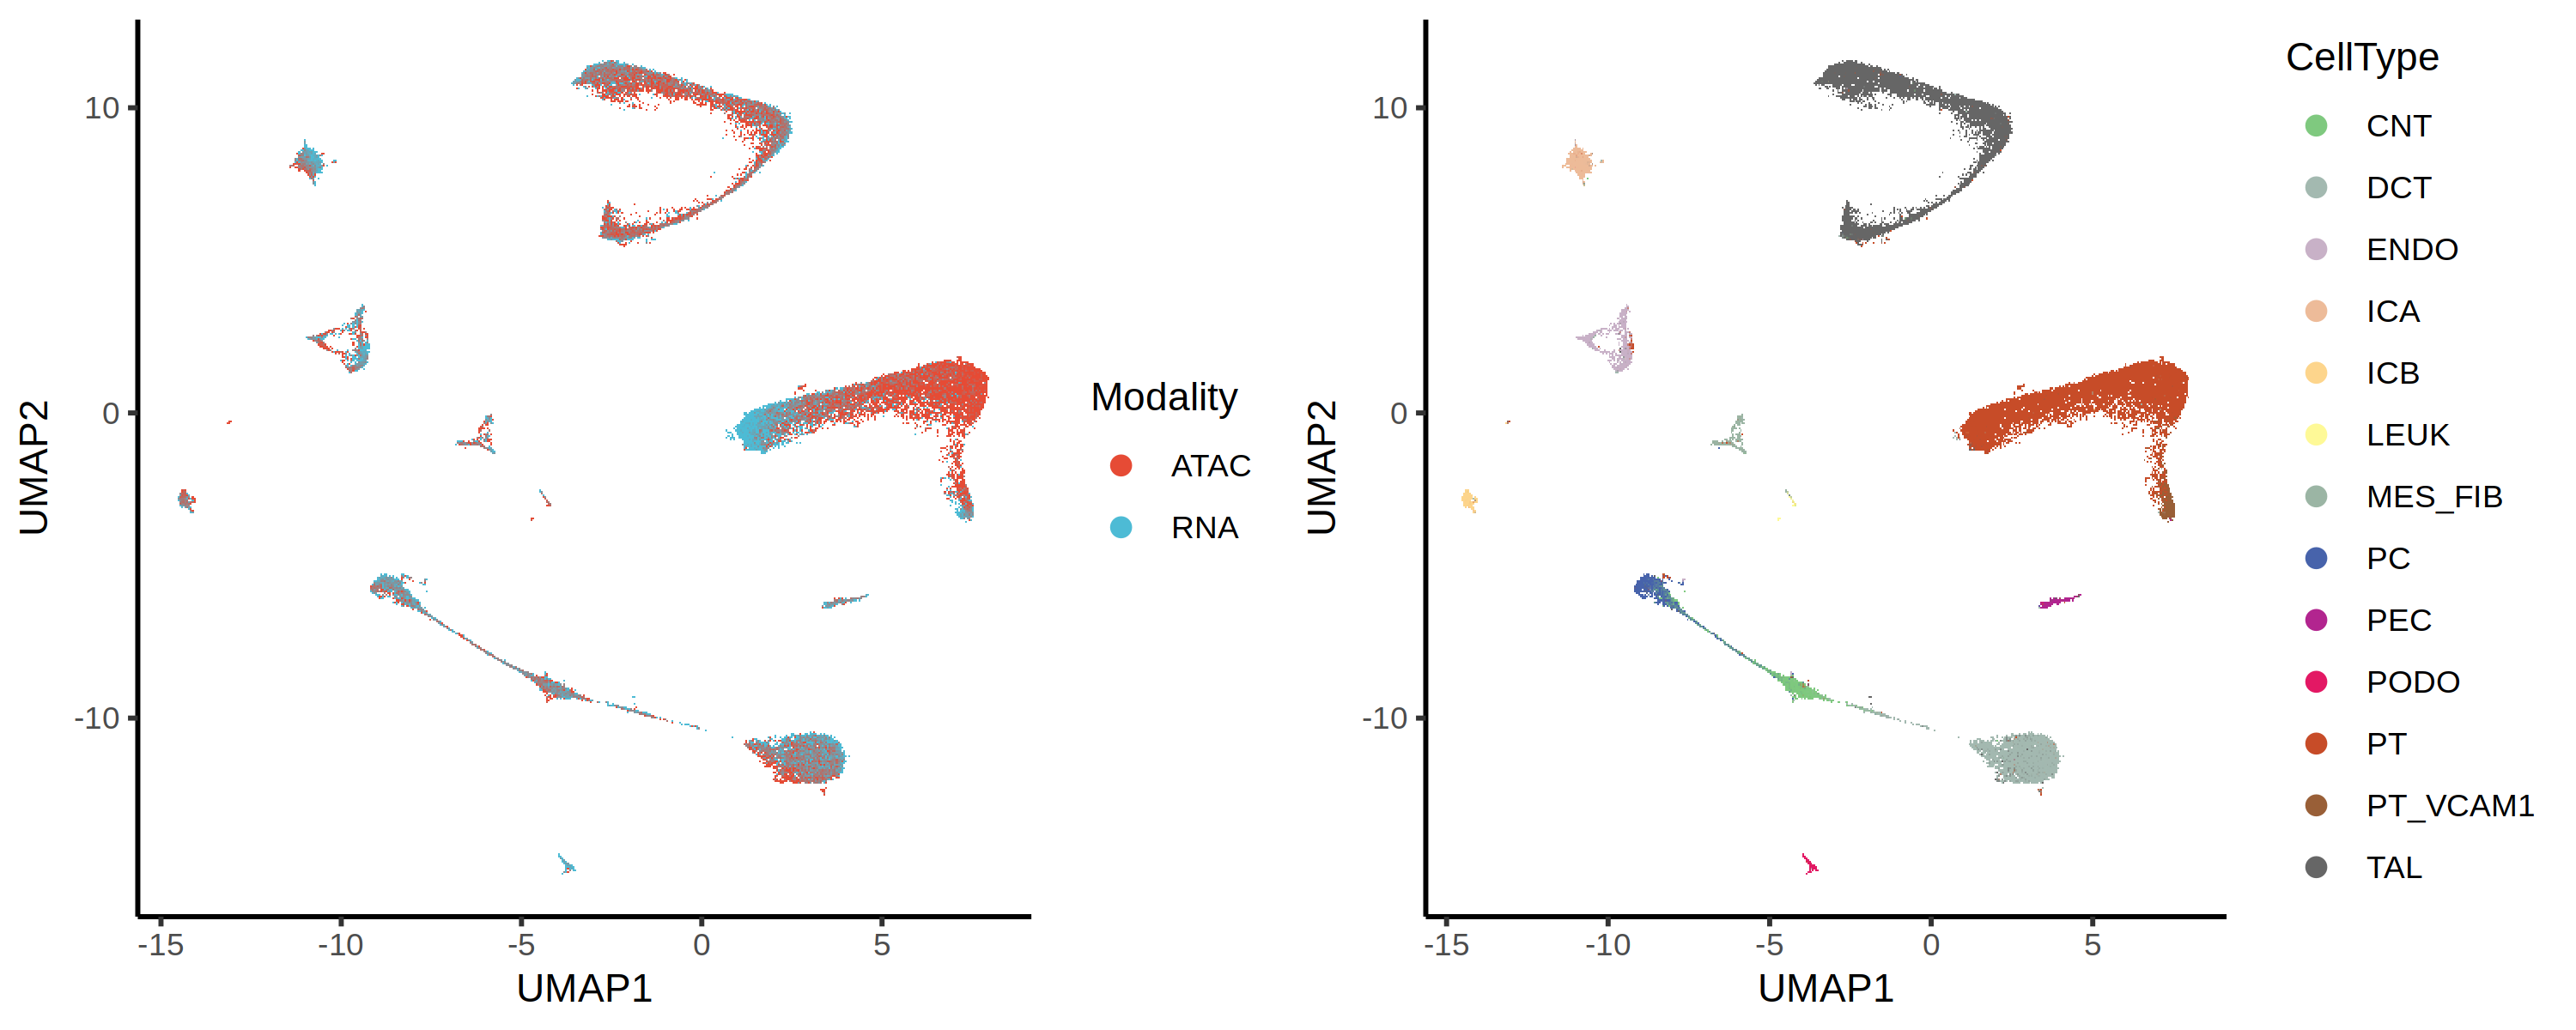

In [26]:
p1 <- ggplot(Palette_umap, aes(UMAP1, UMAP2, color = Modality)) +
  geom_scattermore(pointsize = 1) +
  scale_color_npg() +
  guides(colour = guide_legend(override.aes = list(size = 2))) +
  theme_classic()+
  theme(legend.position = "right")

Colors = colorRampPalette(brewer.pal(12, "Accent"))(13)
p2 <- ggplot(Palette_umap, aes(UMAP1, UMAP2, color = CellType)) +
  geom_scattermore(pointsize = 1) +
  scale_color_manual(values = Colors) +  
  guides(colour = guide_legend(override.aes = list(size = 2))) +
  theme_classic()+
  theme(legend.position = "right")


fig.size(4,10)
plot_grid(p1, p2, align = 'h', axis = "b",nrow = 1,rel_widths = c(5,5))

## Session Info

In [27]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 22.10

Matrix products: default
BLAS/LAPACK: /home/server/anaconda3/envs/sqy/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] ggsci_3.0.3           scattermore_1.2       ggplot2_3.5.1        
 [4] RColorBrewer_1.1-3    uwot_0.2.2            PaletteSC_0.1.0      
 [7] preprocessCore_1.60.2 Matrix_1.6-5          tibble_3.2.1         
[10] data.table_1.17.4     dplyr_1.1.4           cowplot_1.1.3        
[13] SeuratObject_4.1.4    Seu